In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date

import lightgbm as lgb
from sklearn.model_selection import KFold

import warnings

warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
target_original = pd.read_csv('data/first_data/target_v1.csv')
weather_original = pd.read_csv('data/first_data/weather_v1.csv')
hourly_smp_original = pd.read_csv('data/first_data/hourly_smp_v1.csv')

target = target_original.copy()
weather = weather_original.copy()
hourly_smp = hourly_smp_original.copy()

In [3]:
oil_price_cl_original = pd.read_csv('data/oil/oil_price_cl.csv')
oil_price_du_original = pd.read_csv('data/oil/oil_price_du.csv')
oil_price_brt_original = pd.read_csv('data/oil/oil_price_brt.csv')

oil_price_cl = oil_price_cl_original.copy()
oil_price_du = oil_price_du_original.copy()
oil_price_brt = oil_price_brt_original.copy()

# 1. Oil, Smp, supply 결합된 데이터 만들기
### oil data 3개(du, cl, brt), smp data 3개(min, max, mean), supply 


In [4]:
def date_time_split(data) :
    data['date'] = pd.to_datetime(data['date'])

    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['weekday'] = data['date'].dt.weekday
    data['hour'] = data['date'].dt.hour

    data = data.drop(['date'], axis = 1)

    return data

In [5]:
target = date_time_split(target)
target = target.iloc[:, :-1]

In [6]:
def time_data(data, start, end) :
    
    # time data를 만들기 위해 각 데이터별 날짜의 최대 최솟값을 저장해둠
    period = pd.date_range(start = start, end = end)
    
     #time data 생성
    time_data = pd.DataFrame({'date' : period})
    time_data = date_time_split(time_data)
    
    return time_data

In [7]:
def make_oil_data(oil,start, end) :
    #oil_price에서 필요한 column(date, price)만을 추출함 
    oil = oil.iloc[:, 1:3]
    
    # target data의 날짜에 맞춰 sampling
    # oil의 가격은 3개월 이후의 smp에 영향을 미치므로 2017-11-02 이후의 데이터만을 sampling
    oil = oil[(oil['date'] >= start) & (oil['date'] <= end)]
    
    #날짜 순서대로 data를 sorting
    oil.sort_values(by = ['date'], inplace = True)
    
    #index를 0부터 시작되도록 초기화(후에 data를 merge할때 index가 다르면 error 발생)
    oil.reset_index(drop = True, inplace = True)

    oil = date_time_split(oil)

    return oil

In [8]:
def merge_oil(oil_1, oil_2, oil_3, time) :
    
    #time_data를 기준으로 oil data들을 merge함
    # 이때 주말의 oil data들은 존재하지 않으므로 모두 null값으로 들어감
    oil = pd.merge(left = time, right = oil_1, how = 'outer')
    oil = pd.merge(left = oil, right = oil_2, how = 'outer')
    oil = pd.merge(left = oil, right = oil_3, how = 'outer')
    
    #주말 oil data의 null값을 각 column의 평균으로 채움
    fillna = {'du_price' : oil.du_price.mean(), 'cl_price' : oil.cl_price.mean(), 'brt_price' : oil.brt_price.mean()}
    oil = oil.fillna(value = fillna)
    
    #oil 데이터의 날짜정보를 필요없으므로 drop
    oil = oil.iloc[ : , -3: ]
    
    return oil

In [9]:
oil_price_cl.columns = ['place', 'date', 'cl_price']
oil_price_du.columns = ['place', 'date', 'du_price']
oil_price_brt.columns = ['place', 'date', 'brt_price']

start = '2017-11-02'
end = '2019-11-01'

In [10]:
oil_cl = make_oil_data(oil_price_cl, start, end)
oil_du = make_oil_data(oil_price_du, start, end)
oil_brt = make_oil_data(oil_price_brt, start, end)

time = time_data(oil_cl, start, end)

In [11]:
oil = merge_oil(oil_cl, oil_du, oil_brt, time)

In [12]:
target = pd.concat([target, oil], axis = 1)
target

,smp_max,smp_min,smp_mean,supply,year,month,day,weekday,cl_price,du_price,brt_price
0,150.65,116.84,132.71,87.47,2018,2,1,3,54.540000,58.870000,60.620000
1,163.86,116.84,134.19,86.64,2018,2,2,4,55.640000,60.150000,62.070000
2,164.07,116.85,131.39,88.28,2018,2,3,5,60.888469,66.191494,67.863066
3,171.00,115.76,131.89,86.14,2018,2,4,6,60.888469,66.191494,67.863066
4,170.34,123.89,137.96,90.63,2018,2,5,0,57.350000,61.830000,64.270000
...,...,...,...,...,...,...,...,...,...,...,...
725,154.46,78.95,94.07,76.64,2020,1,27,0,55.810000,59.450000,61.570000
726,156.57,84.80,103.05,80.25,2020,1,28,1,55.540000,59.410000,61.590000
727,154.78,86.99,109.21,82.90,2020,1,29,2,55.060000,59.320000,60.610000
728,203.15,84.87,112.85,84.85,2020,1,30,3,54.180000,58.450000,60.230000


# 2. temp 일단위로 변경

In [13]:
def temp_preprocessing(data) :
    
    #weather data에서 temp와 date를 제외한 모든 column drop
    data = data[data['area'] == 884]
    data = data.iloc[:, 1:3]
    data.reset_index(drop = True, inplace = True)
    data.columns = ['date', 'temp']
    
    #weather data의 date를 year, month, day, weekday, hour로 분해해줌
    data = date_time_split(data)
    
    #2018년 2월 1일 00시 데이터와 2019년 2월 1일 00시 데이터 누락
    #해당 데이터를 채워줌
    column = data.columns
    
    first_data = [round(data[data['month'] ==2]['temp'].mean(), 1) , 2018, 2, 1, 3, 0]
    second_data = [round(data[data['month'] ==2]['temp'].mean(), 1), 2019, 2, 1, 4, 0]
    time_data = [first_data, second_data]
    time_data = pd.DataFrame(time_data, columns = column)
    data = pd.concat([data, time_data])
    
    data.sort_values(by = ['year', 'month', 'day', 'weekday', 'hour'], inplace = True)
    data.reset_index(drop = True, inplace = True)
    
    return data

In [14]:
def make_daily_temp(data, window_size, daily_size) :
    
    #하루치 데이터마다 sampling하여 dict 자료구조로 저장
    weather_dict = {}
    for window in range(daily_size) :
        weather_dict[window] = data.iloc[window_size*window+1 : window_size*(window+1), : ]
        
    
    #동일한 기간의 날짜정보만 담은 dataframe 만들기
    start = '2018-02-01'
    end = '2020-01-31'

    period = pd.date_range(start = start, end = end)
    period = pd.DataFrame({'date' : period})
    period = date_time_split(period)
    period = period.iloc[ : , :-1]
    
    #시간별 온도들을 모아 하루치 평균 온도를 계산
    mean_temp = [0] * daily_size
    for window in range(daily_size) :
        mean_temp[window] = round(weather_dict[window]['temp'].mean(),1)
    
    period['temp'] = mean_temp
    
    return period

In [15]:
daily_size = 730
window_size = 24

weather = temp_preprocessing(weather)
weather = make_daily_temp(data = weather, window_size = window_size, daily_size = daily_size)
weather.head()

,year,month,day,weekday,temp
0,2018,2,1,3,4.2
1,2018,2,2,4,4.6
2,2018,2,3,5,0.7
3,2018,2,4,6,-1.7
4,2018,2,5,0,-0.5


# 3. target과 weather를 합쳐 train 데이터 제작

In [16]:
train = pd.merge(left = weather, right = target, on = ['year', 'month', 'day', 'weekday'])

time = train['year'].astype(str) + '-' + train['month'].astype(str) + '-' + train['day'].astype(str)
train['date'] = pd.to_datetime(time)

train = train[['date', 'year', 'month', 'day', 'weekday', 'temp', 'cl_price', 'du_price', 'brt_price', 'smp_min', 'smp_max', 'smp_mean', 'supply']]

In [17]:
train

,date,year,month,day,weekday,temp,cl_price,du_price,brt_price,smp_min,smp_max,smp_mean,supply
0,2018-02-01,2018,2,1,3,4.2,54.540000,58.870000,60.620000,116.84,150.65,132.71,87.47
1,2018-02-02,2018,2,2,4,4.6,55.640000,60.150000,62.070000,116.84,163.86,134.19,86.64
2,2018-02-03,2018,2,3,5,0.7,60.888469,66.191494,67.863066,116.85,164.07,131.39,88.28
3,2018-02-04,2018,2,4,6,-1.7,60.888469,66.191494,67.863066,115.76,171.00,131.89,86.14
4,2018-02-05,2018,2,5,0,-0.5,57.350000,61.830000,64.270000,123.89,170.34,137.96,90.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-01-27,2020,1,27,0,9.9,55.810000,59.450000,61.570000,78.95,154.46,94.07,76.64
726,2020-01-28,2020,1,28,1,9.1,55.540000,59.410000,61.590000,84.80,156.57,103.05,80.25
727,2020-01-29,2020,1,29,2,8.9,55.060000,59.320000,60.610000,86.99,154.78,109.21,82.90
728,2020-01-30,2020,1,30,3,7.2,54.180000,58.450000,60.230000,84.87,203.15,112.85,84.85


# 4. Predict 'temp' and 'supply'

In [18]:
def create_model(train, val):
    params = {
        'metric': 'mae',
        'seed':7777
        }

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(model.predict(x_val), '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()

    return model

In [19]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [20]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

In [21]:
x_columns = ['year', 'month', 'day', 'weekday', 'supply', 'temp', 'cl_price', 'du_price', 'brt_price']
y_columns = ['supply']
supply_models = {}

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's l1: 6.20417


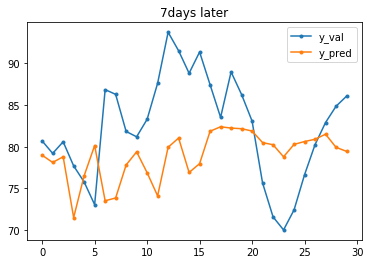

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 5.60883


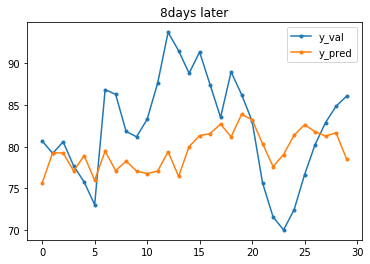

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	valid_0's l1: 6.28926


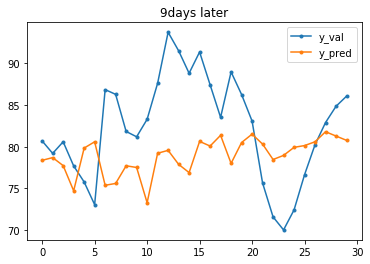

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's l1: 6.77567


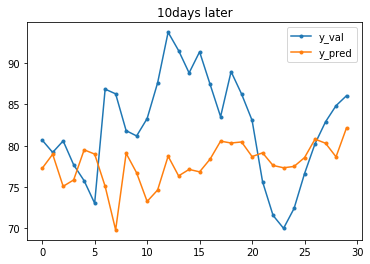

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 7.54992


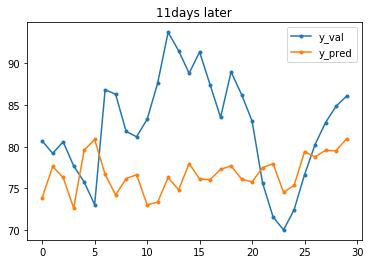

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 8.31679
Did not meet early stopping. Best iteration is:
[987]	valid_0's l1: 8.31674


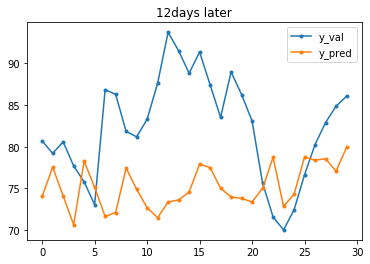

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 7.67243


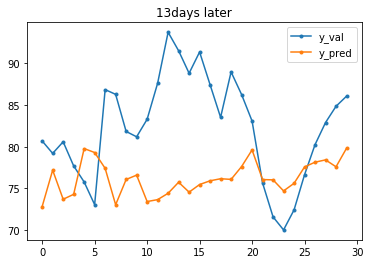

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 7.77088


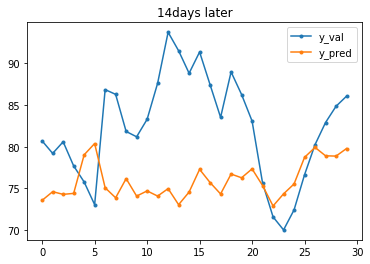

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 7.71969


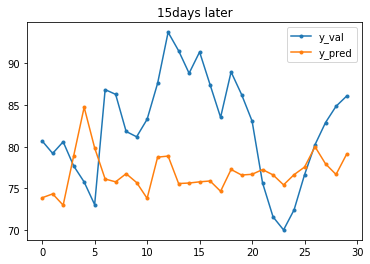

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 7.89059


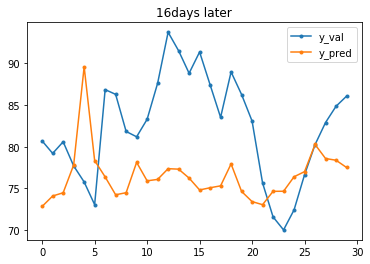

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 8.19288


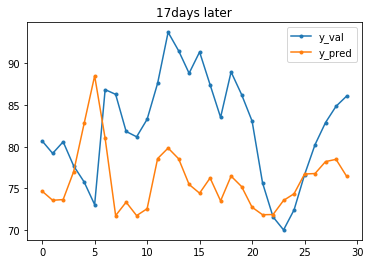

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 6.71097


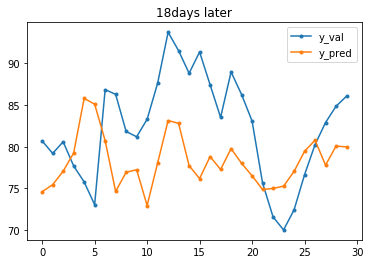

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 7.80802


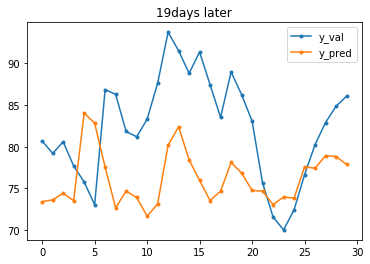

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 7.81181


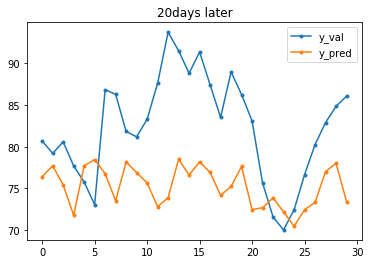

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 7.62147


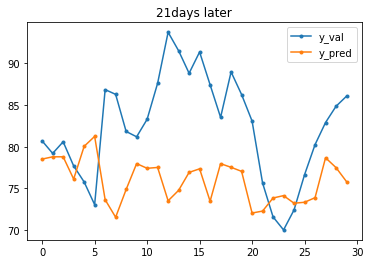

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 5.91862


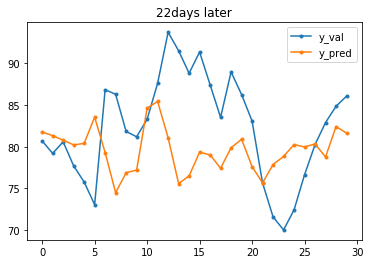

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 6.54875


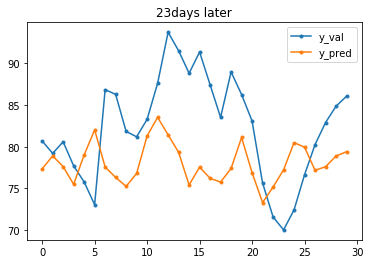

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 5.01884


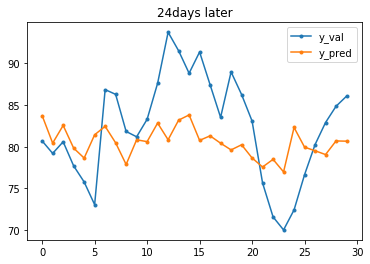

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 4.62855


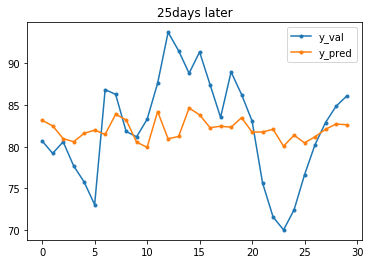

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's l1: 4.68708


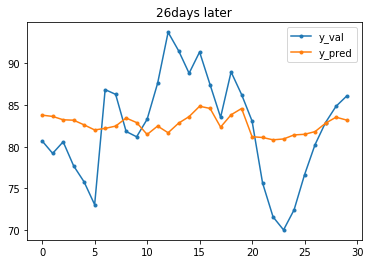

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 4.47133


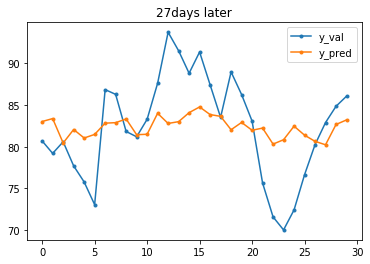

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's l1: 4.45629


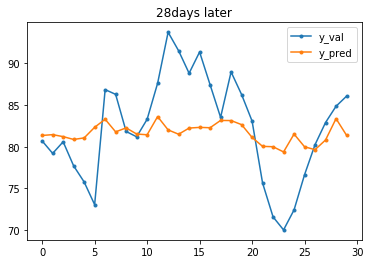

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 4.62384


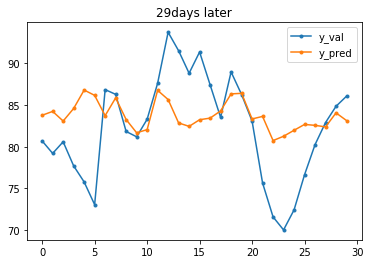

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	valid_0's l1: 5.04325


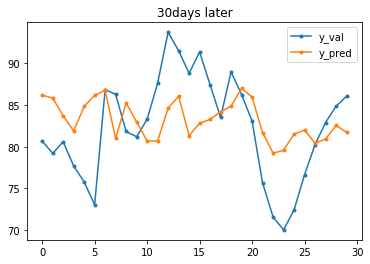

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's l1: 4.96873


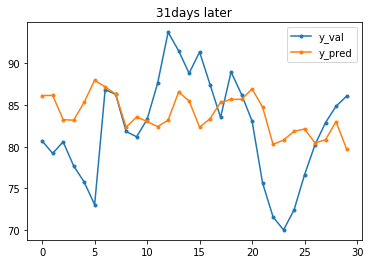

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 5.19343
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 5.19343


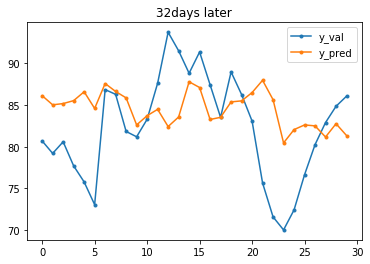

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 5.249


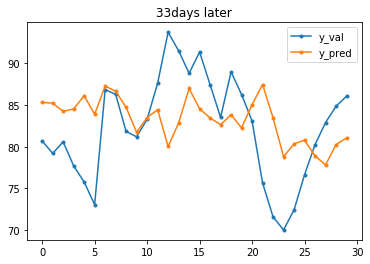

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 5.59014


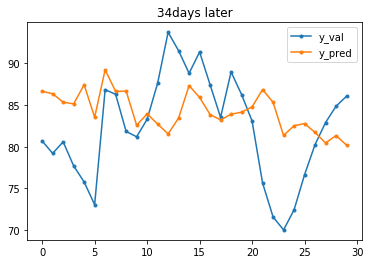

In [22]:
# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = train.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(train, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(train, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    supply_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

In [23]:
x_columns = ['year', 'month', 'day', 'temp']
y_columns = ['temp']
temp_max_models = {}

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.56262


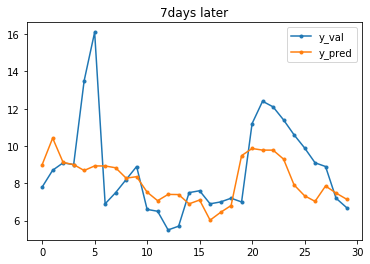

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.58917


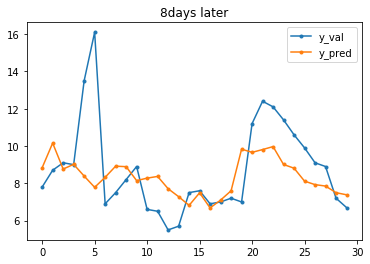

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.57954


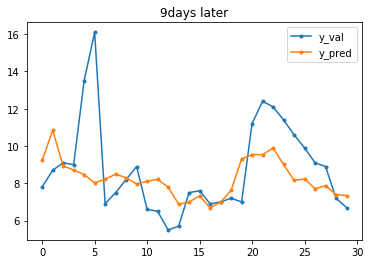

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.68166


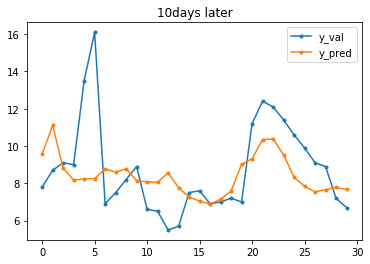

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.71169


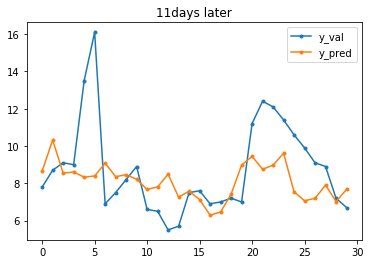

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.71914


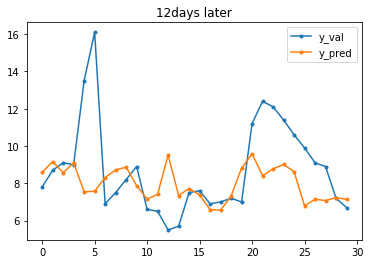

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.74682


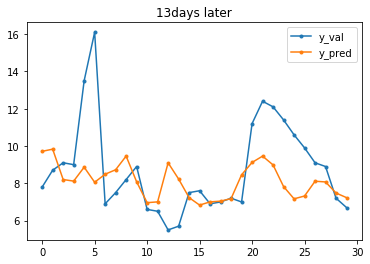

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.70993


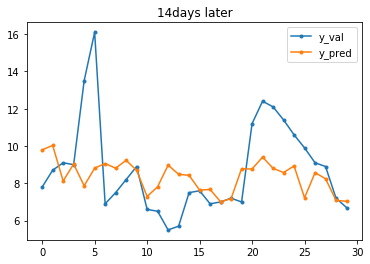

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.76733


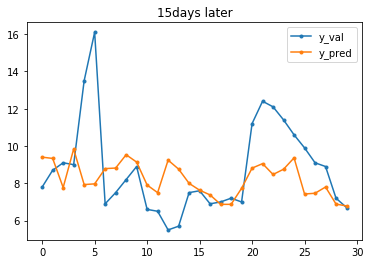

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.623


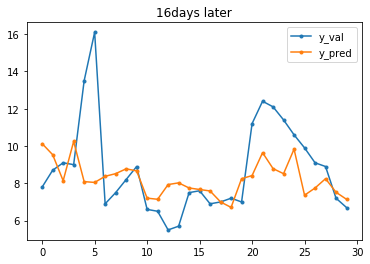

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.54192


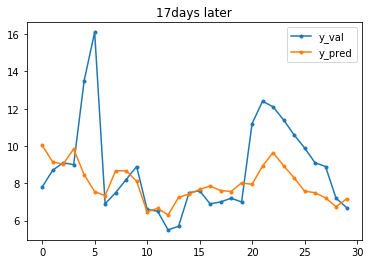

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.51001


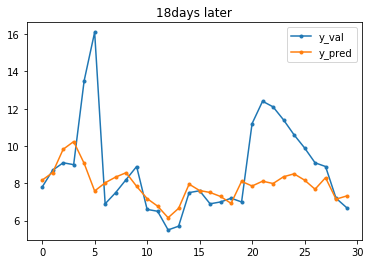

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.48975


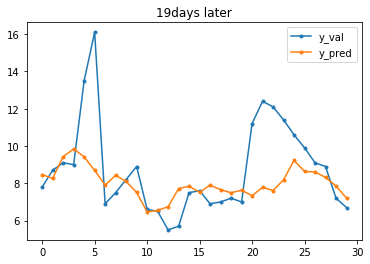

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.45079


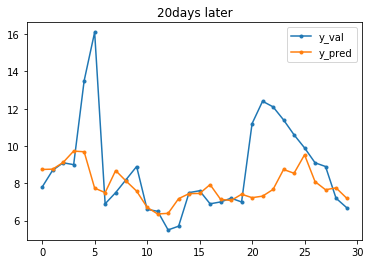

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.49103


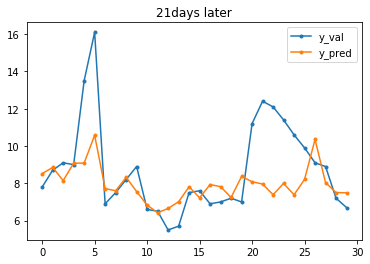

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.57162


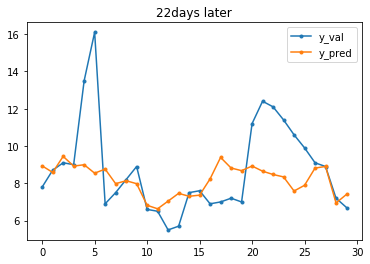

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.63153


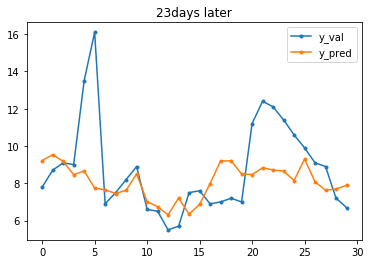

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.5949


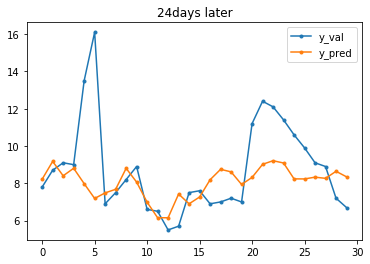

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.60141


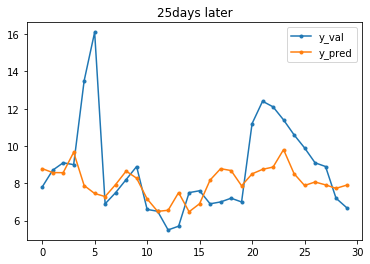

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.54251


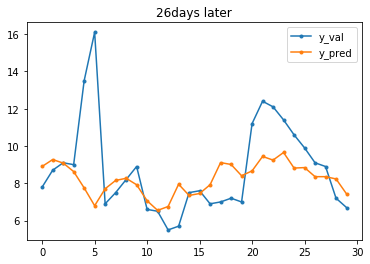

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.73559


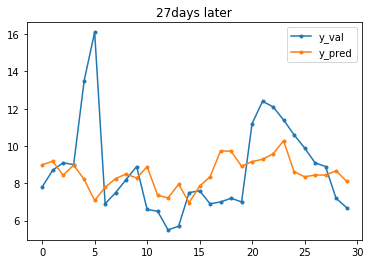

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.84784


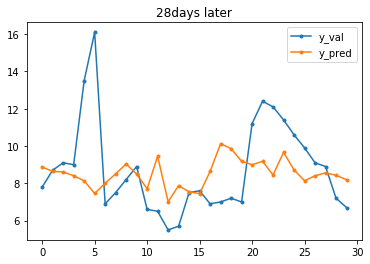

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.86321


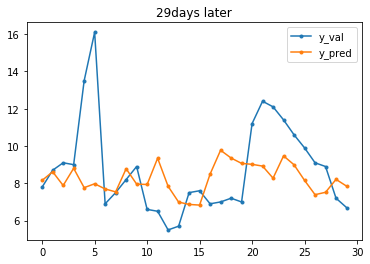

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.81607


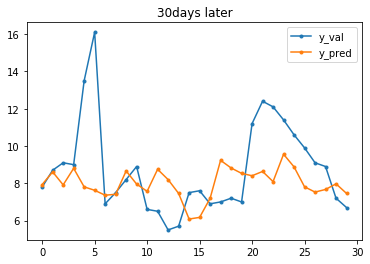

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.84549


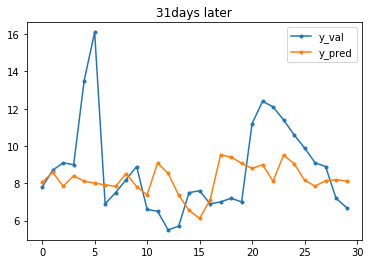

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.75023


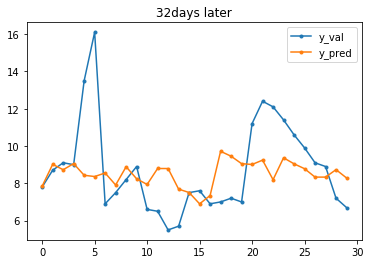

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.79616


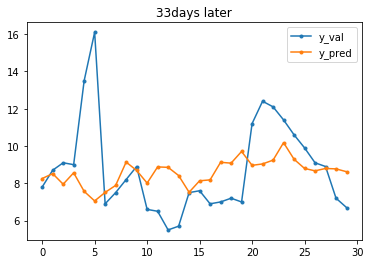

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.73302


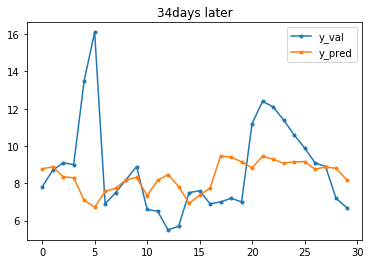

In [24]:
# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = train.shape[0]-past-future-30
    x_train, y_train = trans(train, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(train, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_max_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

# 5. Make submission format oil data

**2020-02-07 ~ 2020-03-05 데이터**  
**oil data는 2019-11-08 ~ 2019-12-05**

In [25]:
oil_price_cl.columns = ['place', 'date', 'cl_price']
oil_price_du.columns = ['place', 'date', 'du_price']
oil_price_brt.columns = ['place', 'date', 'brt_price']

start = '2019-11-08'
end = '2019-12-05'

In [26]:
oil_price_cl = make_oil_data(oil_price_cl, start, end)
oil_price_du = make_oil_data(oil_price_du, start, end)
oil_price_brt = make_oil_data(oil_price_brt, start, end)

time = time_data(oil_price_cl, start, end)

In [27]:
test = pd.merge(left = time, right = oil_price_du, on =['year', 'month', 'day', 'weekday'], how = 'outer')
test = pd.merge(left = test, right = oil_price_cl, on =['year', 'month', 'day', 'weekday'], how = 'outer')
test = pd.merge(left = test, right = oil_price_brt, on =['year', 'month', 'day', 'weekday'], how = 'outer')

In [28]:
test = test.iloc[:, 5 : -1]
test = test[['cl_price', 'du_price', 'brt_price', 'hour_x', 'hour_y']]
test = test.iloc[: ,  :3]

In [29]:
fillna = {'du_price' : oil.du_price.mean(), 'cl_price' : oil.cl_price.mean(), 'brt_price' : oil.brt_price.mean()}
test = test.fillna(value = fillna)

In [30]:
start = '2020-02-07'
end = '2020-03-05'

time = pd.date_range(start = start, end = end)

In [31]:
test['date'] = time
test = test[['date', 'cl_price', 'du_price', 'brt_price']]

In [32]:
def create_smp_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        params = {
            'metric': 'mse',
            'seed':777
            }

        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
        
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(model.predict(x_val), '.-', label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)

    return models

train column :  smp_min
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l2: 498.788


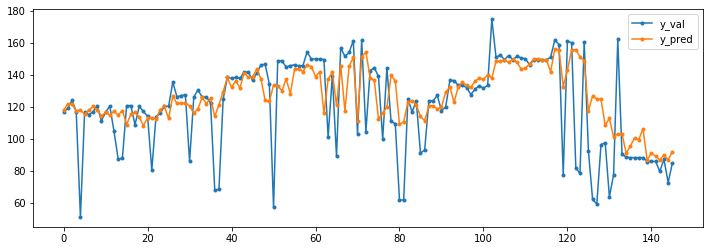

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 274.756


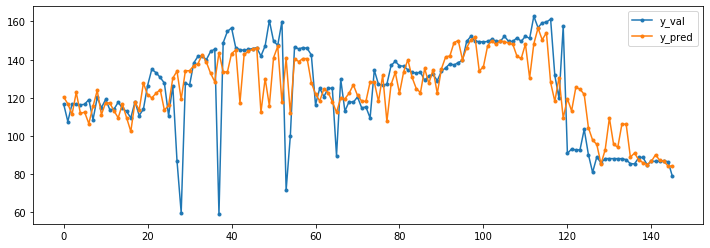

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l2: 295.223


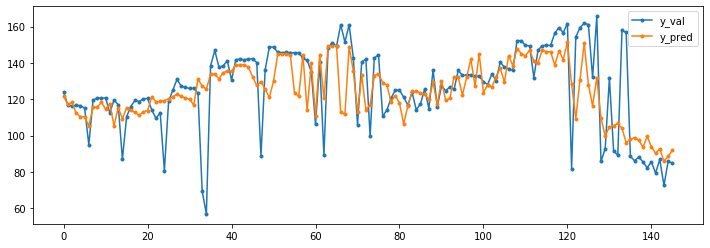

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 195.981


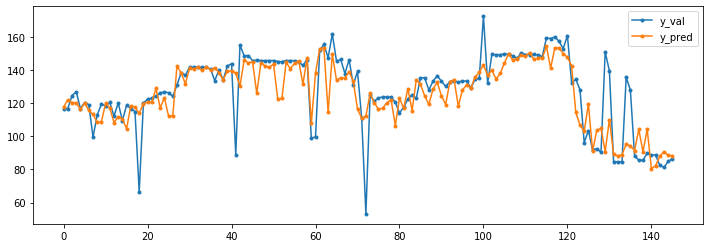

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 149.398


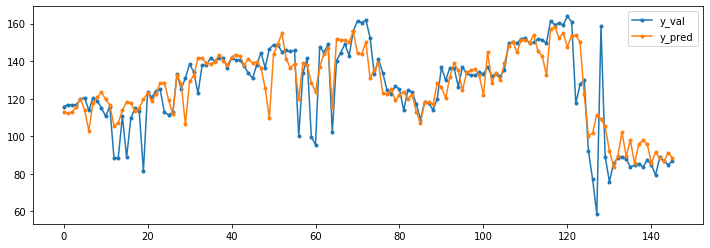

train column :  smp_max
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l2: 380.175


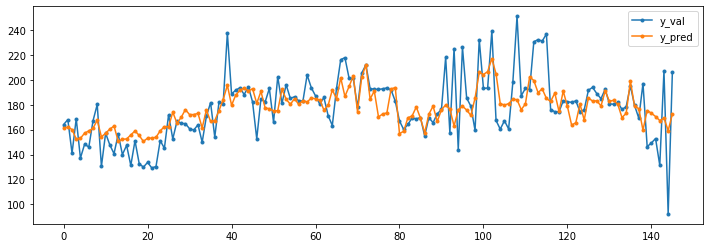

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 311.616


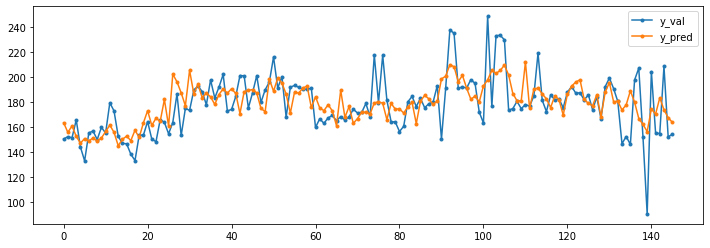

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l2: 258.532


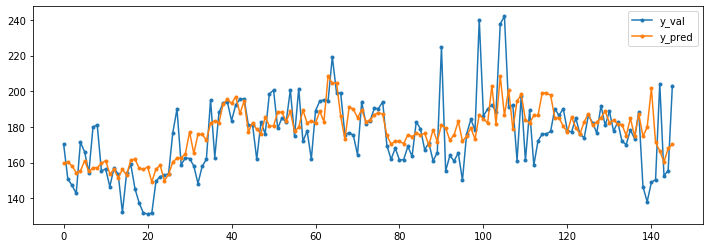

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's l2: 1385


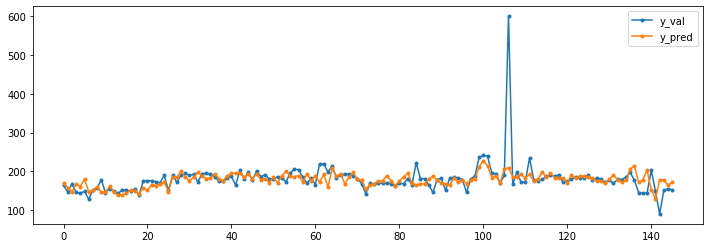

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 796.187


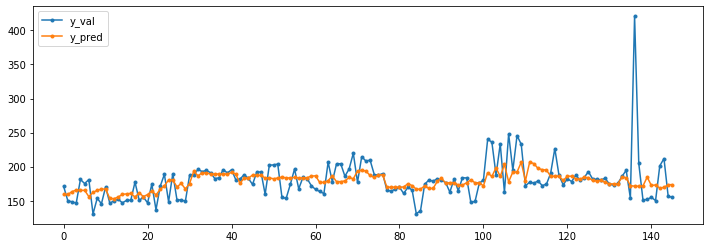

train column :  smp_mean
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's l2: 62.8753


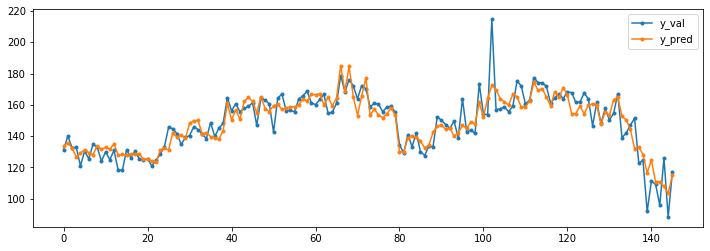

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	valid_0's l2: 77.933


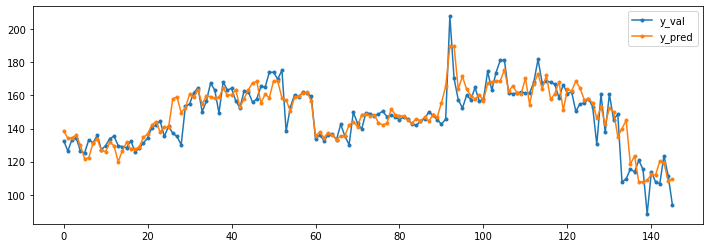

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	valid_0's l2: 52.1355


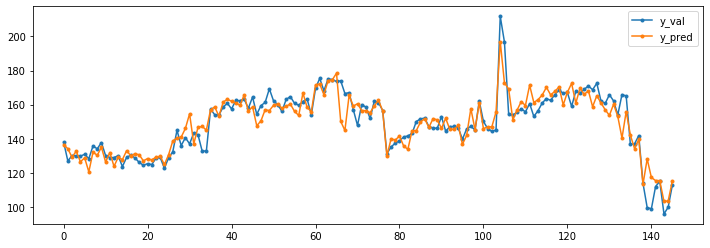

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's l2: 85.5459


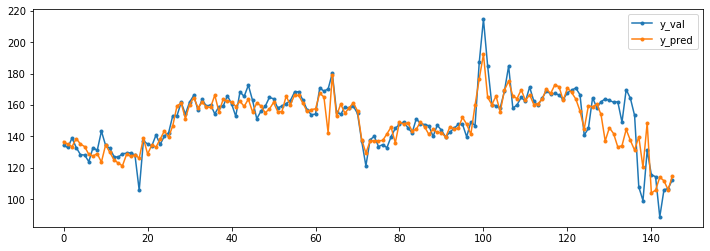

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's l2: 65.8093


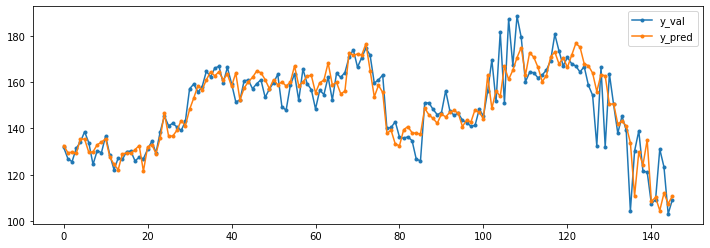

In [33]:
x_train = train.loc[:, ['supply', 'year', 'month', 'day', 'weekday', 'temp', 'cl_price', 'du_price', 'brt_price']]
y_train = train.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_smp_model(x_train, y_train[label])
    print('==========================================================================')

# 6. submission 형태로 변환

In [34]:
x_test = np.array(train.loc[700:, ['supply', 'year', 'month', 'day', 'weekday', 'temp', 'cl_price', 'du_price', 'brt_price', 'smp_min', 'smp_max', 'smp_mean']])
x_test = x_test.reshape(1,-1)

In [35]:
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

In [36]:
x_test = np.array(train.loc[700:, ['supply', 'year', 'month', 'day', 'weekday', 'temp', 'cl_price', 'du_price', 'brt_price', 'smp_min', 'smp_max', 'smp_mean']])
x_test = x_test.reshape(1,-1)

In [37]:
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [38]:
submission = pd.read_csv('data/sample_submission.csv')
submission_bottom_half = submission.loc[28:,:]
submission = submission.loc[:27, :]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday
test['supply'] = np.array(supply_result).reshape(-1)

In [39]:
test

,date,smp_max,smp_min,smp_mean,supply,year,month,day,weekday
0,2020-02-07,0,0,0,79.696798,2020,2,7,4
1,2020-02-08,0,0,0,77.954694,2020,2,8,5
2,2020-02-09,0,0,0,78.705489,2020,2,9,6
3,2020-02-10,0,0,0,77.474617,2020,2,10,0
4,2020-02-11,0,0,0,75.626484,2020,2,11,1
5,2020-02-12,0,0,0,75.315278,2020,2,12,2
6,2020-02-13,0,0,0,75.718742,2020,2,13,3
7,2020-02-14,0,0,0,78.927038,2020,2,14,4
8,2020-02-15,0,0,0,81.404383,2020,2,15,5
9,2020-02-16,0,0,0,79.290709,2020,2,16,6


# 7. 구해진 smp를 submission 형태에 대입

In [40]:
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'weekday', 'smp_min', 'smp_max', 'smp_mean']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [41]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
#submission = pd.concat([submission, submission_bottom_half], axis = 0)

In [42]:
submission

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,165.922010,89.254684,109.385473,79.696798
1,2020-02-08,165.508928,87.593830,107.874526,77.954694
2,2020-02-09,166.148075,88.218339,107.595093,78.705489
3,2020-02-10,164.998450,86.734368,106.241216,77.474617
4,2020-02-11,157.783018,86.735959,106.488838,75.626484
5,2020-02-12,159.636688,86.715376,106.695915,75.315278
6,2020-02-13,161.650657,87.327817,108.611037,75.718742
7,2020-02-14,168.018473,89.545669,109.246566,78.927038
8,2020-02-15,170.298485,91.059996,111.326552,81.404383
9,2020-02-16,168.087208,89.550939,110.504420,79.290709


In [43]:
submission.to_csv('output/first.csv', index = False)